<a href="https://colab.research.google.com/github/bominwang/inviscid-viscid-flow-correct-neural-network/blob/HB-2-surface-pressure/HB2_SurfacePressurePredicate_NNAS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive 
drive.mount('/content/drive')
import pdb

Mounted at /content/drive


In [2]:
import torch
import random
import pandas as pd
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset
import matplotlib
from matplotlib import pyplot as plt
import tqdm
from tqdm import trange

In [3]:
!pip install optuna
import optuna
from optuna.visualization import plot_optimization_history

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.3/365.3 KB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.6/210.6 KB 25.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 KB 10.3 MB/s eta 0:00:00


In [4]:
SEED = 42

np.random.seed(SEED)

In [5]:
def building_dataset(ins_path, lab_path, train_volume, device):
  ins = pd.read_csv(ins_path)
  labs = pd.read_csv(lab_path)
  
  ins = np.array(ins)
  labs = np.array(labs)
  labs = labs[:,1].reshape(-1,10)

  data_volume = ins.shape[0]
  test_volume = data_volume - train_volume
  
  data_index = list(range(data_volume))
  train_index = random.sample(range(0, data_volume), train_volume)
  test_index = np.setdiff1d(data_index, train_index)

  train_data_ins = torch.from_numpy(ins[train_index, :])
  train_data_labs = torch.from_numpy(labs[train_index, :])
  
  test_data_ins = torch.from_numpy(ins[test_index, :])
  test_data_labs = torch.from_numpy(labs[test_index, :])
  
  train_set = TensorDataset(train_data_ins, train_data_labs)
  train_set = DataLoader(train_set, batch_size = train_volume, shuffle = True)
  
  test_set = TensorDataset(test_data_ins, test_data_labs)
  test_set = DataLoader(test_set, batch_size = test_volume, shuffle = True)

  return train_set, test_set

In [6]:
def relative_root_mean_squared_error(pred, true):
  size = pred.size(dim = 1)
  error = torch.zeros(size, 1)
  normalization_factor = torch.zeros(size, 1)
  for index in range(size):
    pred_element = pred[index, :]
    true_element = true[index, :]
    error[index, :] = torch.dot(pred_element - true_element, pred_element - true_element)
    normalization_factor[index,:] = torch.dot(true_element, true_element)
  return torch.sqrt(torch.div(torch.sum(error),torch.sum(normalization_factor)))

In [7]:
class inviscid_nn(nn.Module):
  def __init__(self, hyperparameter):
    super(inviscid_nn, self).__init__()

    self.in_features = 2
    self.num_layer = hyperparameter.suggest_int('num_layer',1,4)
    self.layer = []

    for i in range(self.num_layer):
      self.out_features = hyperparameter.suggest_int(f'num_neurons_{i}', 50, 200)
      self.layer.append(nn.Linear(self.in_features, self.out_features))
      self.layer.append(nn.ReLU())
      self.p = hyperparameter.suggest_float(f'dropout_{i}', 0.2, 0.5)
      self.layer.append(nn.Dropout(self.p))
      self.in_features = self.out_features
    self.hidden_layer = nn.Sequential(*self.layer)
    self.out_layer = nn.Sequential(
        nn.Linear(self.in_features, 10)
    )
  def forward(self,x):
    x = self.hidden_layer(x)
    y = self.out_layer(x)
    return y

In [8]:
def objective_function(hyperparameter):
  model = inviscid_nn(hyperparameter).to(device)

  lr = hyperparameter.suggest_float('lr',1e-5, 1e-1, log = True)

  optimizer_name = hyperparameter.suggest_categorical("optimizer", ["Adam", "RMSprop", "SGD"])
  optimizer = getattr(optim, optimizer_name)(model.parameters(), lr=lr)

  loss_name = hyperparameter.suggest_categorical('loss_function',['MSELoss','SmoothL1Loss','L1Loss'])
  loss_function = getattr(nn, loss_name)()

  ins_path = 'drive/MyDrive/Colab Notebooks/bm_wang/data/HB2/inv/inv_input_data.csv'
  labs_path = 'drive/MyDrive/Colab Notebooks/bm_wang/data/HB2/inv/inv_output_data.csv'
  train_set, test_set = building_dataset(ins_path, labs_path, 100, device)

  epoches = 200
  for epoch in range(epoches):
    for index, (ins, lab) in enumerate(train_set):
      model.train()
      ins = Variable(ins).reshape(-1,2).to(torch.float32).to(device)
      lab = Variable(lab).reshape(-1,10).to(torch.float32).to(device)
      optimizer.zero_grad()
      pred = model(ins)
      rmse = loss_function(pred, lab)
      rmse.backward()
      optimizer.step()

    model.eval()
    with torch.no_grad():
      for index, (ins, lab) in enumerate(test_set):
        ins = ins.reshape(-1,2).to(torch.float32).to(device)
        lab = lab.reshape(-1,10).to(torch.float32).to(device)
        pred = model(ins)
        rrmse = relative_root_mean_squared_error(pred, lab)

    hyperparameter.report(rrmse, epoch)
  return rrmse

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

study = optuna.create_study(study_name = 'inviscid_nn', direction= 'minimize')
study.optimize(objective_function, n_trials = 200, timeout = 1200)

pruned_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.PRUNED]
complete_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE]

best_hyperparameter = study.best_params

[I 2023-02-11 04:35:32,763] A new study created in memory with name: inviscid_nn
[I 2023-02-11 04:35:44,407] Trial 0 finished with value: 0.07175455242395401 and parameters: {'num_layer': 1, 'num_neurons_0': 184, 'dropout_0': 0.39516890260309745, 'lr': 0.006206791288589126, 'optimizer': 'Adam', 'loss_function': 'SmoothL1Loss'}. Best is trial 0 with value: 0.07175455242395401.
[I 2023-02-11 04:35:46,410] Trial 1 finished with value: 0.25227808952331543 and parameters: {'num_layer': 2, 'num_neurons_0': 132, 'dropout_0': 0.2148745268712953, 'num_neurons_1': 194, 'dropout_1': 0.44281807989276445, 'lr': 0.0006141244569214905, 'optimizer': 'Adam', 'loss_function': 'MSELoss'}. Best is trial 0 with value: 0.07175455242395401.
[I 2023-02-11 04:35:48,088] Trial 2 finished with value: 0.15261210501194 and parameters: {'num_layer': 1, 'num_neurons_0': 195, 'dropout_0': 0.27910341909919, 'lr': 3.792542467586709e-05, 'optimizer': 'RMSprop', 'loss_function': 'MSELoss'}. Best is trial 0 with value: 0.

In [10]:
plot_optimization_history(study)

In [11]:
class inviscid_nn(nn.Module):
  def __init__(self, hyperparameter):
    super(inviscid_nn, self).__init__()
    
    self.in_features = 2
    self.num_layer = hyperparameter['num_layer']
    self.layer = []

    for i in range(self.num_layer):
      self.out_features = hyperparameter[f'num_neurons_{i}']
      self.layer.append(nn.Linear(self.in_features, self.out_features))
      self.layer.append(nn.ReLU())
      self.p = hyperparameter[f'dropout_{i}']
      self.layer.append(nn.Dropout(self.p))
      self.in_features = self.out_features
    self.hidden_layer = nn.Sequential(*self.layer)
    self.out_layer = nn.Sequential(
        nn.Linear(self.in_features, 10)
    )
  def forward(self,x):
    x = self.hidden_layer(x)
    y = self.out_layer(x)
    return y

In [12]:
def train_process(model, hyperparameter):
  
  # model = inviscid_nn(study.best_params).to(device)
  train_loss_history = []
  test_loss_history = []
  
  lr = hyperparameter['lr']
  optimizer_name = hyperparameter['optimizer']
  optimizer = getattr(optim, optimizer_name)(model.parameters(), lr = lr)
  loss_name = hyperparameter['loss_function']
  loss_function = getattr(nn, loss_name)()

  ins_path = 'drive/MyDrive/Colab Notebooks/bm_wang/data/HB2/inv/inv_input_data.csv'
  labs_path = 'drive/MyDrive/Colab Notebooks/bm_wang/data/HB2/inv/inv_output_data.csv'

  train_set, test_set = building_dataset(ins_path, labs_path, 100, device)

  epoches = 2000
  for epoch in trange(epoches):
    for index, (ins, lab) in enumerate(train_set):
      model.train()
      ins = Variable(ins).reshape(-1,2).to(torch.float32).to(device)
      lab = Variable(lab).reshape(-1,10).to(torch.float32).to(device)
      optimizer.zero_grad()
      pred = model(ins)
      rmse = loss_function(pred, lab)
      train_loss_history.append(rmse.item())
      rmse.backward()
      optimizer.step()
      
    model.eval()
    with torch.no_grad():
      for index, (ins, lab) in enumerate(test_set):
        ins = ins.reshape(-1,2).to(torch.float32).to(device)
        lab = lab.reshape(-1,10).to(torch.float32).to(device)
        pred = model(ins)
        rrmse = relative_root_mean_squared_error(pred, lab)
        test_loss_history.append(rrmse.item())
  plt.figure(1)
  plt.plot(train_loss_history)
  plt.title('loss of train set')
  print(f'\n无粘网络训练损失函数收敛于{train_loss_history[-1]}')
  plt.figure(2)
  plt.plot(test_loss_history,'g')
  plt.title('loss of test set')
  print(f'\n无粘网络测试集损失函数收敛于{test_loss_history[-1]}')
  return model

100%|██████████| 2000/2000 [00:18<00:00, 109.00it/s]



无粘网络训练损失函数收敛于0.00905198697000742

无粘网络测试集损失函数收敛于0.0762728750705719


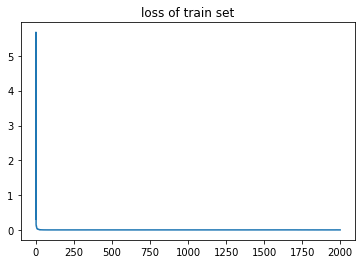

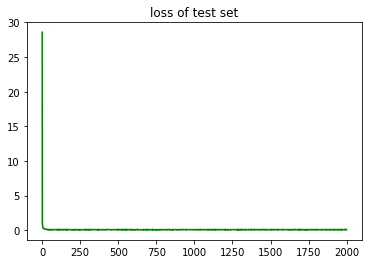

In [13]:
inviscid_nn = train_process(inviscid_nn(study.best_params).to(device), study.best_params)

In [14]:
def visualization_function(model, ins_path, labs_path, device):
  
  visualization_volume = 20

  ins = pd.read_csv(ins_path)
  labs = pd.read_csv(labs_path)
  
  ins = np.array(ins)
  labs = np.array(labs)

  positions = labs[:,0].reshape(-1,10)
  labs = labs[:,1].reshape(-1,10)

  data_volume = ins.shape[0]

  visualization_index = random.sample(range(0, data_volume), visualization_volume)

  ins = torch.from_numpy(ins[visualization_index, :]).to(device)
  labs = torch.from_numpy(labs[visualization_index, :]).to(device)
  positions = torch.from_numpy(positions[visualization_index, :]).to(device)

  pred = model(ins.reshape(-1,2).to(torch.float32))
  
  plt.figure(figsize=(30, 30))
  for i in range(visualization_volume):
    fig1 = plt.subplot(5, 4, i+1)
    position = positions[i, :].reshape(-1,10)
    val_labs = labs[i, :].reshape(-1,10).cpu()
    val_pred = pred[i, :].reshape(-1,10).cpu()
    plt.plot(position.cpu(), val_labs.detach().numpy(),'kv')
    plt.plot(position.cpu(), val_pred.detach().numpy(),'bs')
  plt.show()

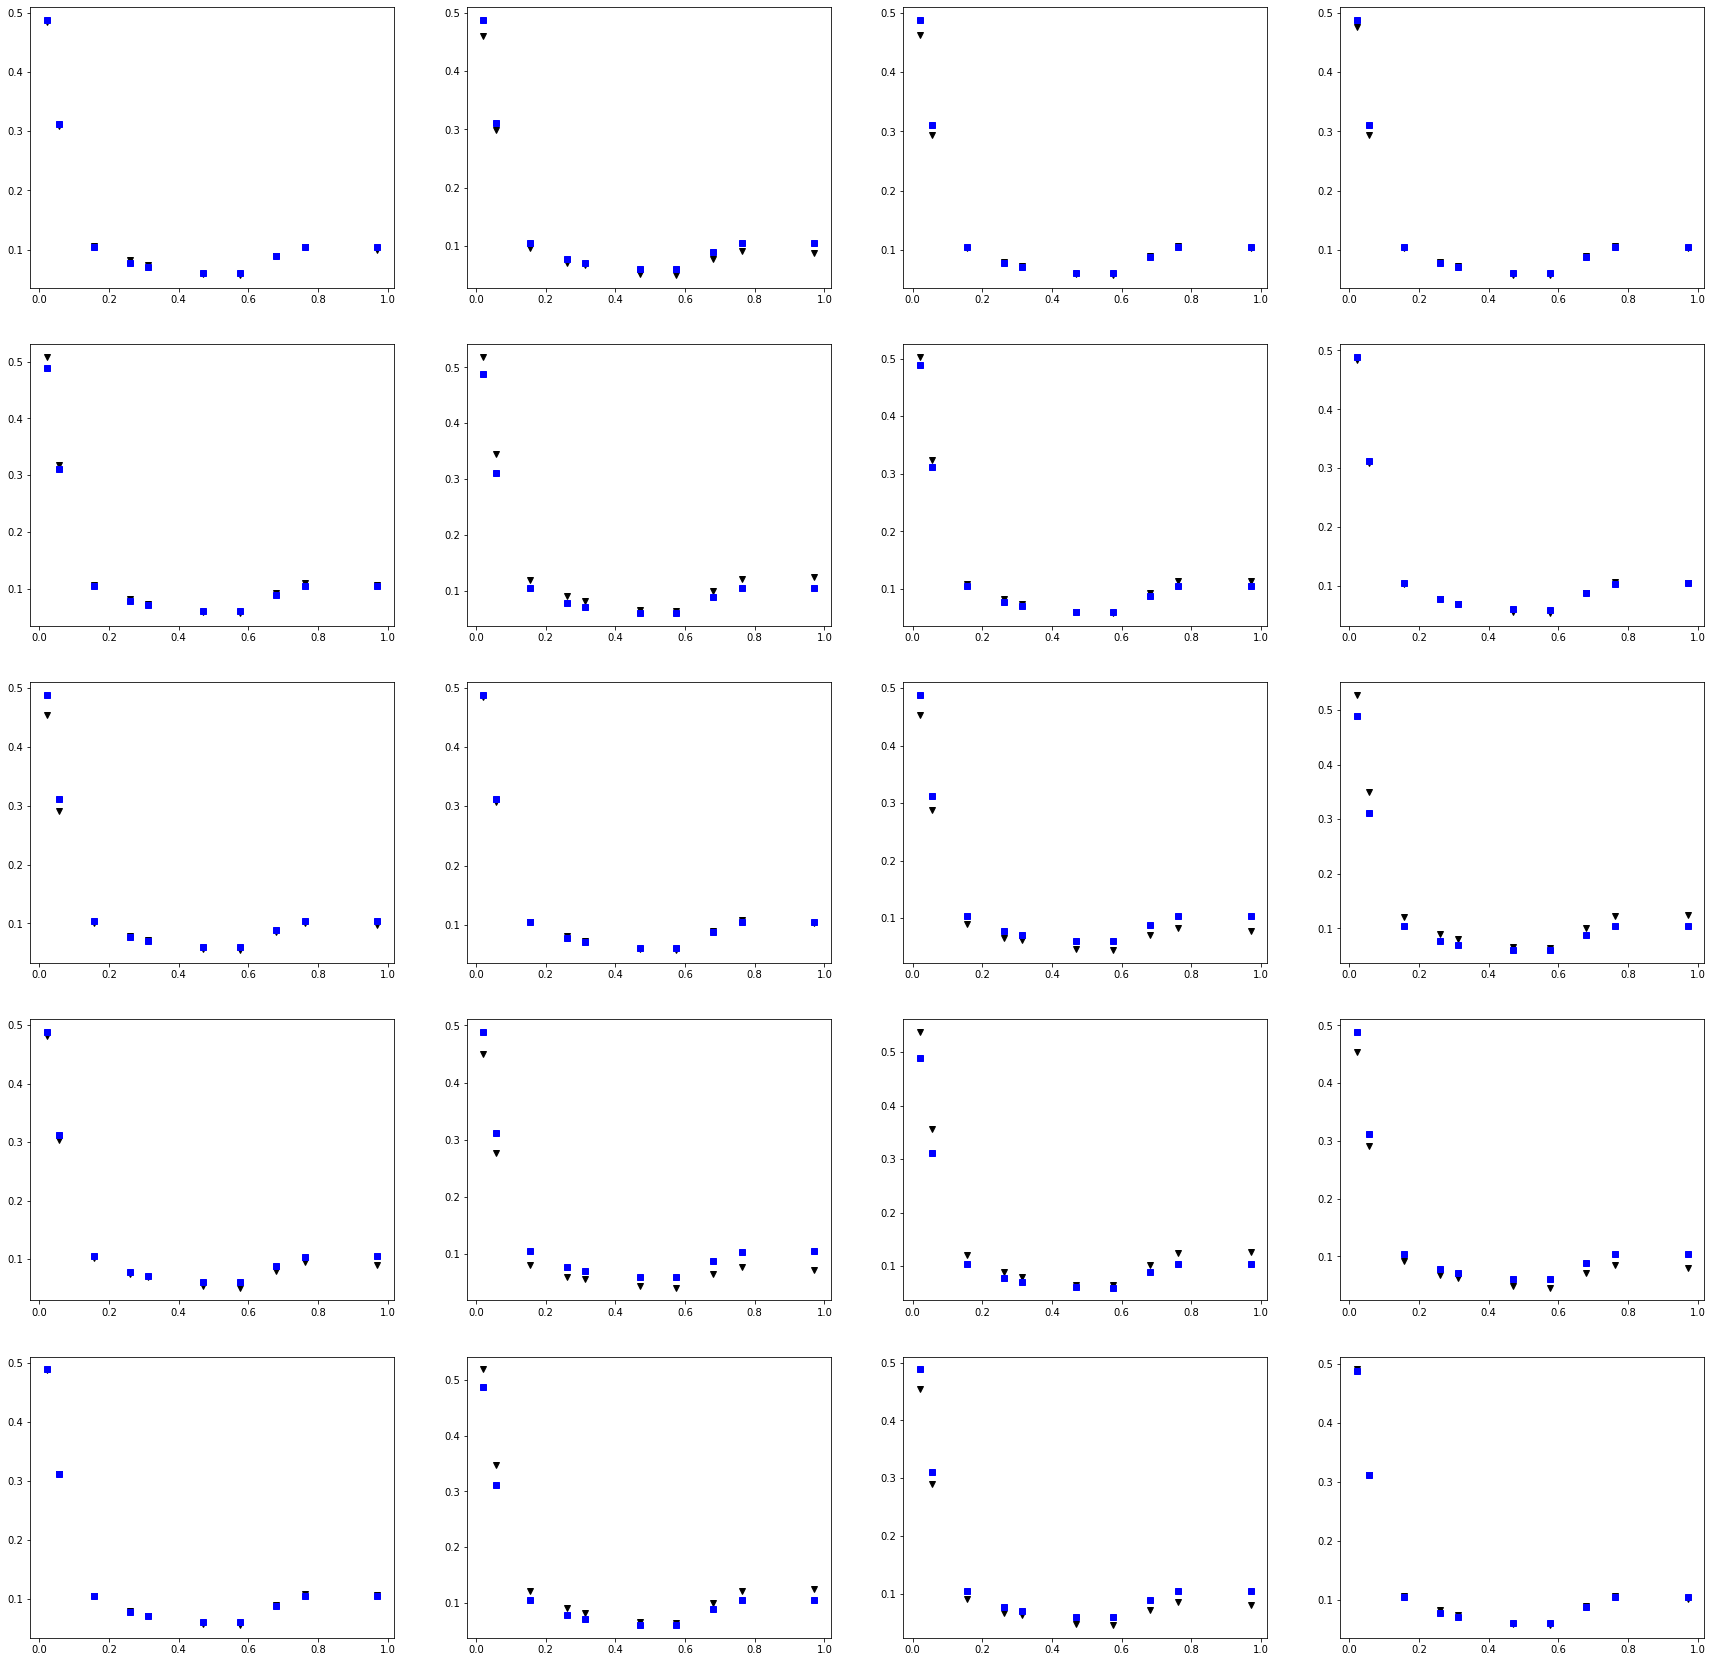

In [15]:
ins_path = 'drive/MyDrive/Colab Notebooks/bm_wang/data/HB2/inv/inv_input_data.csv'
labs_path = 'drive/MyDrive/Colab Notebooks/bm_wang/data/HB2/inv/inv_output_data.csv'
visualization_function(inviscid_nn, ins_path, labs_path, device)

In [16]:
class sa_nn(nn.Module):
  def __init__(self, inviscid_nn, hyperparameter):
    super(sa_nn, self).__init__()
    
    self.inviscid_nn = inviscid_nn
    for preas in self.inviscid_nn.parameters():
      preas.requires_grad=False
    
    self.in_features = 7
    self.num_layer = hyperparameter.suggest_int('num_layer',1,3)
    self.layer = []

    for i in range(self.num_layer):
      self.out_features = hyperparameter.suggest_int(f'num_neurons_{i}', 50, 200)
      self.layer.append(nn.Linear(self.in_features, self.out_features))
      self.layer.append(nn.ReLU())
      self.p = hyperparameter.suggest_float(f'dropout_{i}', 0.2, 0.5)
      self.layer.append(nn.Dropout(self.p))
      self.in_features = self.out_features
    self.hidden_layer = nn.Sequential(*self.layer)
    self.out_layer = nn.Sequential(
        nn.Linear(self.in_features, 10)
    )
  def forward(self,x):
    
    x1 = x[:, 0:2]
    x1 = self.inviscid_nn(x1)
    
    x2 = x[:, 2:10]
    x2 = self.hidden_layer(x2)
    x2 = self.out_layer(x2)
    
    y = x1 + x2
    
    return y

In [17]:
def objective_function(hyperparameter):
  
  model = sa_nn(inviscid_nn, hyperparameter).to(device)

  lr = hyperparameter.suggest_float('lr',1e-3, 1e-1, log = True)

  #optimizer_name = hyperparameter.suggest_categorical("optimizer", ["Adam", "RMSprop", "SGD"])
  #optimizer = getattr(optim, optimizer_name)(model.parameters(), lr=lr)
  #loss_name = hyperparameter.suggest_categorical('loss_function',['MSELoss','SmoothL1Loss','L1Loss'])
  #loss_function = getattr(nn, loss_name)()
  loss_function = nn.MSELoss()
  optimizer = optim.SGD(model.parameters(), lr = lr)
  
  ins_path = 'drive/MyDrive/Colab Notebooks/bm_wang/data/HB2/sa/sa_input_data.csv'
  labs_path = 'drive/MyDrive/Colab Notebooks/bm_wang/data/HB2/sa/sa_output_data.csv'
  train_set, test_set = building_dataset(ins_path, labs_path, 20, device)

  epoches = 1000
  for epoch in range(epoches):
    for index, (ins, lab) in enumerate(train_set):
      model.train()
      ins = Variable(ins).reshape(-1,9).to(torch.float32).to(device)
      lab = Variable(lab).reshape(-1,10).to(torch.float32).to(device)
      optimizer.zero_grad()
      pred = model(ins)
      rmse = loss_function(pred, lab)
      rmse.backward()
      optimizer.step()

    model.eval()
    with torch.no_grad():
      for index, (ins, lab) in enumerate(test_set):
        ins = ins.reshape(-1,9).to(torch.float32).to(device)
        lab = lab.reshape(-1,10).to(torch.float32).to(device)
        pred = model(ins)
        rrmse = relative_root_mean_squared_error(pred, lab)

    hyperparameter.report(rrmse, epoch)
  return rrmse

In [18]:
study = optuna.create_study(study_name = 'sa_nn', direction= 'minimize')
study.optimize(objective_function, n_trials = 200, timeout = 1200)

pruned_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.PRUNED]
complete_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE]

plot_optimization_history(study)

best_hyperparameter = study.best_params

[I 2023-02-11 04:40:12,695] A new study created in memory with name: sa_nn
[I 2023-02-11 04:40:17,567] Trial 0 finished with value: 0.12660598754882812 and parameters: {'num_layer': 2, 'num_neurons_0': 112, 'dropout_0': 0.40815728349826963, 'num_neurons_1': 76, 'dropout_1': 0.2571755301431336, 'lr': 0.019519131617190048}. Best is trial 0 with value: 0.12660598754882812.
[I 2023-02-11 04:40:21,552] Trial 1 finished with value: 0.06194741651415825 and parameters: {'num_layer': 1, 'num_neurons_0': 57, 'dropout_0': 0.4369095017858664, 'lr': 0.059611093595606277}. Best is trial 1 with value: 0.06194741651415825.
[I 2023-02-11 04:40:26,488] Trial 2 finished with value: 0.05492885410785675 and parameters: {'num_layer': 1, 'num_neurons_0': 175, 'dropout_0': 0.3003195757602709, 'lr': 0.09734557238697755}. Best is trial 2 with value: 0.05492885410785675.
[I 2023-02-11 04:40:30,718] Trial 3 finished with value: 0.19244642555713654 and parameters: {'num_layer': 2, 'num_neurons_0': 174, 'dropout_0'

In [19]:
plot_optimization_history(study)

# type1


```
def define_inviscid_nn(hyperparameter):
  num_layers = hyperparameter.suggest_int('num_layers', 1, 4)
  layer = []
  in_features = 2
  # hidden layer
  for i in range(num_layers):
    out_features = hyperparameter.suggest_int(f'n_neurons_{i}', 10, 400)
    layer.append(nn.Linear(in_features, out_features))
    layer.append(nn.ReLU())
    p = hyperparameter.suggest_float(f'dropout_{i}', 0.2, 0.5)
    layer.append(nn.Dropout(p))
    in_features = out_features
  # output layer
  layer.append(nn.Linear(in_features, 10))
  
  return nn.Sequential(*layer)
     
```




```
def objective_function(hyperparameter):
  model = define_inviscid_nn(hyperparameter).to(device)
  
  lr = hyperparameter.suggest_float('lr',1e-5, 1e-1, log = True)
  optimizer = optim.SGD(model.parameters(), lr = lr)
  loss_function = nn.MSELoss()
  
  ins_path = 'drive/MyDrive/Colab Notebooks/bm_wang/data/HB2/inv/inv_input_data.csv'
  labs_path = 'drive/MyDrive/Colab Notebooks/bm_wang/data/HB2/inv/inv_output_data.csv'
  
  train_set, test_set = building_dataset(ins_path, labs_path, 100, device)
  
  epoches = 1000
  for epoch in range(epoches):
    for index, (ins, lab) in enumerate(train_set):
      model.train()
      ins = Variable(ins).reshape(-1,2).to(torch.float32).to(device)
      lab = Variable(lab).reshape(-1,10).to(torch.float32).to(device)
      optimizer.zero_grad()
      pred = model(ins)
      rmse = loss_function(pred, lab)
      rmse.backward()
      optimizer.step()

    model.eval()
    with torch.no_grad():
      for index, (ins, lab) in enumerate(test_set):
        ins = ins.reshape(-1,2).to(torch.float32).to(device)
        lab = lab.reshape(-1,10).to(torch.float32).to(device)
        pred = model(ins)
        rrmse = relative_root_mean_squared_error(pred, lab)
    
    hyperparameter.report(rrmse, epoch)
  return rrmse
```



# type2



```
class inviscid_nn(nn.Module):
  def __init__(self, hyperparameter):
    super(inviscid_nn, self).__init__()
    
    self.in_features = 2
    self.num_layer = hyperparameter.suggest_int('num_layer',1,4)
    self.layer = []

    for i in range(self.num_layer):
      self.out_features = hyperparameter.suggest_int(f'num_neurons_{i}', 10, 400)
      self.layer.append(nn.Linear(self.in_features, self.out_features))
      self.layer.append(nn.ReLU())
      self.p = hyperparameter.suggest_float(f'dropout_{i}', 0.2, 0.5)
      self.layer.append(nn.Dropout(self.p))
      self.in_features = self.out_features
    self.hidden_layer = nn.Sequential(*self.layer)
    self.out_layer = nn.Sequential(
        nn.Linear(self.in_features, 10)
    )
  def forward(self,x):
    x = self.hidden_layer(x)
    y = self.out_layer(x)
    return y
```





```
def objective_function(hyperparameter):
  model = inviscid_nn(hyperparameter).to(device)
  
  lr = hyperparameter.suggest_float('lr',1e-5, 1e-1, log = True)
  
  optimizer_name = hyperparameter.suggest_categorical("optimizer", ["Adam", "RMSprop", "SGD"])
  optimizer = getattr(optim, optimizer_name)(model.parameters(), lr=lr)
  
  loss_name = hyperparameter.suggest_categorical('loss_function',['MSELoss','SmoothL1Loss','L1Loss'])
  loss_function = getattr(nn, loss_name)()
  
  ins_path = 'drive/MyDrive/Colab Notebooks/bm_wang/data/HB2/inv/inv_input_data.csv'
  labs_path = 'drive/MyDrive/Colab Notebooks/bm_wang/data/HB2/inv/inv_output_data.csv'
  train_set, test_set = building_dataset(ins_path, labs_path, 100, device)
  
  epoches = 1000
  for epoch in range(epoches):
    for index, (ins, lab) in enumerate(train_set):
      model.train()
      ins = Variable(ins).reshape(-1,2).to(torch.float32).to(device)
      lab = Variable(lab).reshape(-1,10).to(torch.float32).to(device)
      optimizer.zero_grad()
      pred = model(ins)
      rmse = loss_function(pred, lab)
      rmse.backward()
      optimizer.step()

    model.eval()
    with torch.no_grad():
      for index, (ins, lab) in enumerate(test_set):
        ins = ins.reshape(-1,2).to(torch.float32).to(device)
        lab = lab.reshape(-1,10).to(torch.float32).to(device)
        pred = model(ins)
        rrmse = relative_root_mean_squared_error(pred, lab)
    
    hyperparameter.report(rrmse, epoch)
  return rrmse
```

